<a href="https://colab.research.google.com/github/hajsf/Time-Series-Forecast/blob/main/05_TrainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import glob
import numpy as np

In [3]:
# import required library
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pickle

**Read the pickle files**





In [4]:
pathData = "/content/drive/MyDrive/ColabNotebooks/dataset/02_ProcessedData/"

In [6]:
with open(pathData + '124766.pk', 'rb') as f:
  df = pickle.load(f)
df.head()

,SLS_CNTR_ID,DATE1,QTY,isSalaryweek,Holiday,AcademicCalendarSemester,isWeekend,isNationalday,isRamadan,isRamadanEnd,...,Category_Cancelled,Category_HomeMade,Category_HomeMadewithVAT,Category_Imported,Category_Itproducts,Category_Local,Category_Packaging,Category_Partner,Category_RawMaterial,Category_SisterCompany
395998,5,2022-01-12,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
395999,13,2022-01-12,22.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
396000,19,2022-01-12,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
396001,20,2022-01-12,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
396002,24,2022-01-12,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [7]:
df.set_index("DATE1", inplace = True)

In [8]:
print("number of records:", len(df))

number of records: 18184


**Train / Test Split**

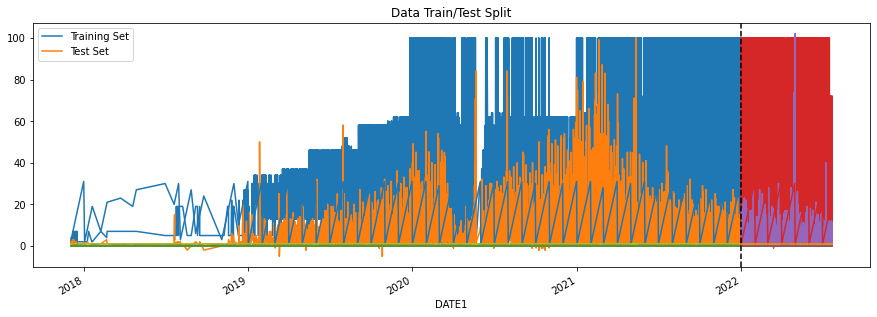

In [9]:
train = df.loc[df.index.get_level_values('DATE1') < '2022-01-01'] # df.index.get_level_values('DATE1').dayofweek == 0
test = df.loc[df.index.get_level_values('DATE1') >= '2022-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2022-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [11]:
test.head()

,SLS_CNTR_ID,QTY,isSalaryweek,Holiday,AcademicCalendarSemester,isWeekend,isNationalday,isRamadan,isRamadanEnd,isEid,...,Category_Cancelled,Category_HomeMade,Category_HomeMadewithVAT,Category_Imported,Category_Itproducts,Category_Local,Category_Packaging,Category_Partner,Category_RawMaterial,Category_SisterCompany
DATE1,,,,,,,,,,,,,,,,,,,,,
2022-01-12,5,4.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2022-01-12,13,22.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2022-01-12,19,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2022-01-12,20,7.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2022-01-12,24,3.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


**Create the Model**

In [31]:
#DataFrame.dtypes for data must be int, float or bool, so we are removing 'ITEM_ID' and 'DATE1'
FEATURES = ['SLS_CNTR_ID', 'isSalaryweek', 'AcademicCalendarSemester', 'isWeekend', 'isRamadan', 'isRamadanEnd', 'isEid', 'isNationalday']
TARGET = 'QTY'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [32]:
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror', # instead of 'reg:linear' that is deprecated 
                       max_depth=3,
                       learning_rate=0.01)

In [33]:
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:10.5772	validation_1-rmse:5.83036
[100]	validation_0-rmse:7.68943	validation_1-rmse:4.0241
[200]	validation_0-rmse:7.08639	validation_1-rmse:4.32878
[300]	validation_0-rmse:6.91315	validation_1-rmse:4.52555
[400]	validation_0-rmse:6.83335	validation_1-rmse:4.60599
[500]	validation_0-rmse:6.77784	validation_1-rmse:4.63164
[600]	validation_0-rmse:6.7378	validation_1-rmse:4.64469
[700]	validation_0-rmse:6.71203	validation_1-rmse:4.66854
[800]	validation_0-rmse:6.69055	validation_1-rmse:4.70104
[900]	validation_0-rmse:6.67375	validation_1-rmse:4.74411
[999]	validation_0-rmse:6.6619	validation_1-rmse:4.77784


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000,
             objective='reg:squarederror')

Save the model

In [35]:
with open(pathData + 'model.pk', 'wb') as f:
  pickle.dump(model, f)

**Feature Importance**

In [ ]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

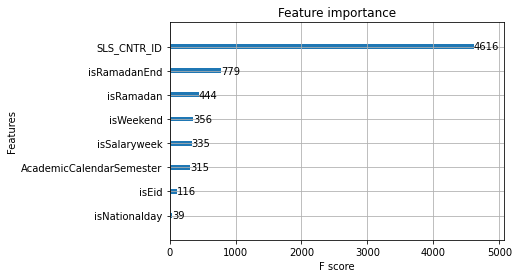

In [36]:
#from xgboost import XGBRegressor
from xgboost import plot_importance
# plot feature importance
plot_importance(model)
plt.show()

**Forecast on Test**

In [41]:
test = test.drop(columns=['prediction'])

In [ ]:
test['prediction'] = model.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df.loc[(df.index > '01-01-2022') & (df.index < '01-08-2022')]['QTY'].plot(figsize=(15, 5)) #df(['QTY'].plot(figsize=(15, 5))
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.') # df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

**Score (RMSE)**

In [ ]:
score = np.sqrt(mean_squared_error(test['salesQty'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

**Calculate Error**


*   Look at the worst and best predicted days

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

**Save weights**


*   Save the model and its weights to be used for predection with other set of data

